In [ ]:
import torch
import numpy as np
import torch.utils.data as data

import anndata as ad
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score
from tqdm import tqdm
from clearml import Logger
import clearml
from clearml import Task
import os
from get_api_keys import get_secret

In [2]:
from model import RNAseqClassifier, get_model_and_optimizer
from dataset import scRNAseqDataset
from train import train_model
from utils import compute_metrics, predict_sample

In [ ]:
adata_all_hvgs = ad.read_h5ad('DATA/ANNDATAS/adata_4488(all)_hvg.h5ad')

In [ ]:
adata_all_hvgs = ad.read_h5ad('DATA/ANNDATAS/adata_4488(all)_hvg.h5ad')
adata_100_hvgs = ad.read_h5ad('DATA/ANNDATAS/adata_100_hvg.h5ad')
adata_200_hvgs = ad.read_h5ad('DATA/ANNDATAS/adata_200_hvg.h5ad')
adata_500_hvgs = ad.read_h5ad('DATA/ANNDATAS/adata_500_hvg.h5ad')
adata_1000_hvgs = ad.read_h5ad('DATA/ANNDATAS/adata_1000_hvg.h5ad')
adata_2000_hvgs = ad.read_h5ad('DATA/ANNDATAS/adata_2000_hvg.h5ad')
adata_10000_hvgs = ad.read_h5ad('DATA/ANNDATAS/adata_10000_hvg.h5ad')
adata_all_genes = ad.read_h5ad('Data/GSE155249_main.h5ad')

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
os.environ["CLEARML_API_ACCESS_KEY"] = get_secret("CLEARML_API_ACCESS_KEY")
os.environ["CLEARML_API_SECRET_KEY"] = get_secret("CLEARML_API_SECRET_KEY")

clearml.browser_login()

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=XXQMNQA0L2KFEQ543XAX5I84ZUPS6Q
env: CLEARML_API_SECRET_KEY=BQtU7Xi6tuKz7ypMjSijeX8l2NmcP6ZWtcVdOJREAfhI7cEZL1SyT94lL585_Vy9M5Y


### Prepare train, val, test data

In [12]:
cells = adata_all_genes.obs_names
y = adata_all_genes.obs['Cluster'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)

cells_train, cells_temp, y_train, y_temp = train_test_split(
    cells, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

cells_val, cells_test, y_val, y_test = train_test_split(
    cells_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

In [13]:
adata_all_genes[cells_train].X.shape

(54002, 21819)

In [14]:
cells_train

Index(['GGGACCTAGTACGTAA-2', 'TCTTTCCTCGTGGACC-15', 'CGGACGTGTTACGCGC-17',
       'TTCGAAGTCTAGCACA-15', 'TGACTTTTCAGGATCT-5', 'CTAGTGAAGGTGCAAC-15',
       'CATTCGCCATGCCTTC-12', 'AGTGTCACACATTCGA-16', 'CTTGGCTCATGCCTTC-6',
       'TACTCATGTAGCACGA-15',
       ...
       'GGAAAGCAGAGGACGG-6', 'CAGTCCTCAGTCCTTC-18', 'CACATTTAGCTAGTCT-14',
       'AGCAGCCGTGGTCCGT-18', 'GGACAGATCCGTCATC-16', 'GTTAAGCAGCTATGCT-6',
       'CGGACGTAGACTAAGT-18', 'TACCTTACACGTAAGG-6', 'CACCTTGAGAGCTATA-15',
       'GACACGCAGAAGGGTA-13'],
      dtype='object', length=54002)

In [15]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 15

In [17]:
torch.manual_seed(111)

for adata in [adata_all_genes]:

    n_hvgs = adata.shape[1]

    X_train = adata[cells_train].X
    X_val = adata[cells_val].X
    #X_test = adata[cells_test].X

    train_dataset = scRNAseqDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = scRNAseqDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = data.DataLoader(val_dataset, batch_size=128, shuffle=True)

    print(f"Training model on {n_hvgs} HVGs")

    model, optimizer = get_model_and_optimizer(
        input_size=X_train.shape[1],
        output_size=len(np.unique(y_train)),
        layer_config=None,
        lr=0.0001,
        weight_decay=0.00001
    )

    task = Task.init(project_name='Modelling', task_name=f'Adata HVGs {n_hvgs} Training')

    train_model(
        model=model,
        model_name=f"{n_hvgs}",
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        task=task
    )

    task.close()

Training model on 21819 HVGs
ClearML Task: created new task id=cb86516685cc47738018a2437f75b0b5


Could not read Jupyter Notebook: No module named 'nbconvert'
Please install nbconvert using "pip install nbconvert"


ClearML results page: https://app.clear.ml/projects/e7ad8385c3454c3f88f0353baedffffb/experiments/cb86516685cc47738018a2437f75b0b5/output/log


Initial Validation: 100%|██████████| 121/121 [00:00<00:00, 155.33it/s]
21819 | Epoch 1/15 [Train]: 100%|██████████| 422/422 [00:05<00:00, 71.19it/s] 
Epoch 1/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 181.77it/s]


Epoch 1/15 | Train Acc: 0.6324 | Val Acc: 0.8087 | Train F1: 0.3321 | Val F1: 0.5545


21819 | Epoch 2/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 110.75it/s]
Epoch 2/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 200.42it/s]


Epoch 2/15 | Train Acc: 0.8443 | Val Acc: 0.8540 | Train F1: 0.5716 | Val F1: 0.6592


21819 | Epoch 3/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 116.17it/s]
Epoch 3/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 172.76it/s]


Epoch 3/15 | Train Acc: 0.9291 | Val Acc: 0.8704 | Train F1: 0.7418 | Val F1: 0.7436


21819 | Epoch 4/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 110.67it/s]
Epoch 4/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 196.27it/s]


Epoch 4/15 | Train Acc: 0.9675 | Val Acc: 0.8702 | Train F1: 0.8129 | Val F1: 0.7543


21819 | Epoch 5/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 111.33it/s]
Epoch 5/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 194.81it/s]


Epoch 5/15 | Train Acc: 0.9828 | Val Acc: 0.8645 | Train F1: 0.8348 | Val F1: 0.7691


21819 | Epoch 6/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 113.50it/s]
Epoch 6/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 202.50it/s]


Epoch 6/15 | Train Acc: 0.9878 | Val Acc: 0.8643 | Train F1: 0.8561 | Val F1: 0.8138


21819 | Epoch 7/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 109.82it/s]
Epoch 7/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 199.83it/s]


Epoch 7/15 | Train Acc: 0.9919 | Val Acc: 0.8641 | Train F1: 0.8908 | Val F1: 0.8475


21819 | Epoch 8/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 110.86it/s]
Epoch 8/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 193.52it/s]


Epoch 8/15 | Train Acc: 0.9938 | Val Acc: 0.8603 | Train F1: 0.9358 | Val F1: 0.8584


21819 | Epoch 9/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 113.74it/s]
Epoch 9/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 207.57it/s]


Epoch 9/15 | Train Acc: 0.9950 | Val Acc: 0.8586 | Train F1: 0.9541 | Val F1: 0.8554


21819 | Epoch 10/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 118.94it/s]
Epoch 10/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 200.54it/s]


Epoch 10/15 | Train Acc: 0.9962 | Val Acc: 0.8604 | Train F1: 0.9798 | Val F1: 0.8607


21819 | Epoch 11/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 115.33it/s]
Epoch 11/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 204.54it/s]


Epoch 11/15 | Train Acc: 0.9969 | Val Acc: 0.8591 | Train F1: 0.9858 | Val F1: 0.8593


21819 | Epoch 12/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 114.92it/s]
Epoch 12/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 202.59it/s]


Epoch 12/15 | Train Acc: 0.9968 | Val Acc: 0.8561 | Train F1: 0.9906 | Val F1: 0.8606


21819 | Epoch 13/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 117.55it/s]
Epoch 13/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 200.62it/s]


Epoch 13/15 | Train Acc: 0.9968 | Val Acc: 0.8561 | Train F1: 0.9921 | Val F1: 0.8584


21819 | Epoch 14/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 109.83it/s]
Epoch 14/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 186.95it/s]


Epoch 14/15 | Train Acc: 0.9974 | Val Acc: 0.8551 | Train F1: 0.9951 | Val F1: 0.8586


21819 | Epoch 15/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 112.54it/s]
Epoch 15/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 206.09it/s]


Epoch 15/15 | Train Acc: 0.9972 | Val Acc: 0.8573 | Train F1: 0.9958 | Val F1: 0.8545


In [26]:
model, optimizer = get_model_and_optimizer(
    input_size=X_train.shape[1],
    output_size=len(np.unique(y_train)),
    layer_config=None,
    lr=0.0001,
    weight_decay=0.00001
)

In [3]:
import json
import matplotlib.pyplot as plt

def plot_from_json(json_path, title, xlabel="Epoch", ylabel="Metric Value"):

    with open(json_path, "r") as f:
        data = json.load(f)

    plt.figure(figsize=(12, 6))

    for trace in data:
        plt.plot(trace["x"], trace["y"], label=trace["name"], marker='o')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
import json
import matplotlib.pyplot as plt

def plot_multiple_jsons_separate_subplots(json_paths, title, xlabel="Epoch", ylabel="Metric Value"):
    """
    Plot traces from multiple JSON files in separate subplots within one figure.

    Parameters:
    - json_paths: list of strings, paths to JSON files
    - title: str, super title for the figure
    - xlabel: str, label for the x-axis
    - ylabel: str, label for the y-axis
    """
    num_plots = len(json_paths)
    fig, axs = plt.subplots(num_plots, 1, figsize=(12, 4 * num_plots), sharex=True)

    if num_plots == 1:
        axs = [axs]  # Ensure axs is iterable if there's only one subplot

    for ax, json_path in zip(axs, json_paths):
        with open(json_path, "r") as f:
            data = json.load(f)

        for trace in data:
            ax.plot(trace["x"], trace["y"], label=trace["name"], marker='o')
        
        ax.set_title(f"{trace['name'].split(' - ')[0]}")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for super title
    plt.show()


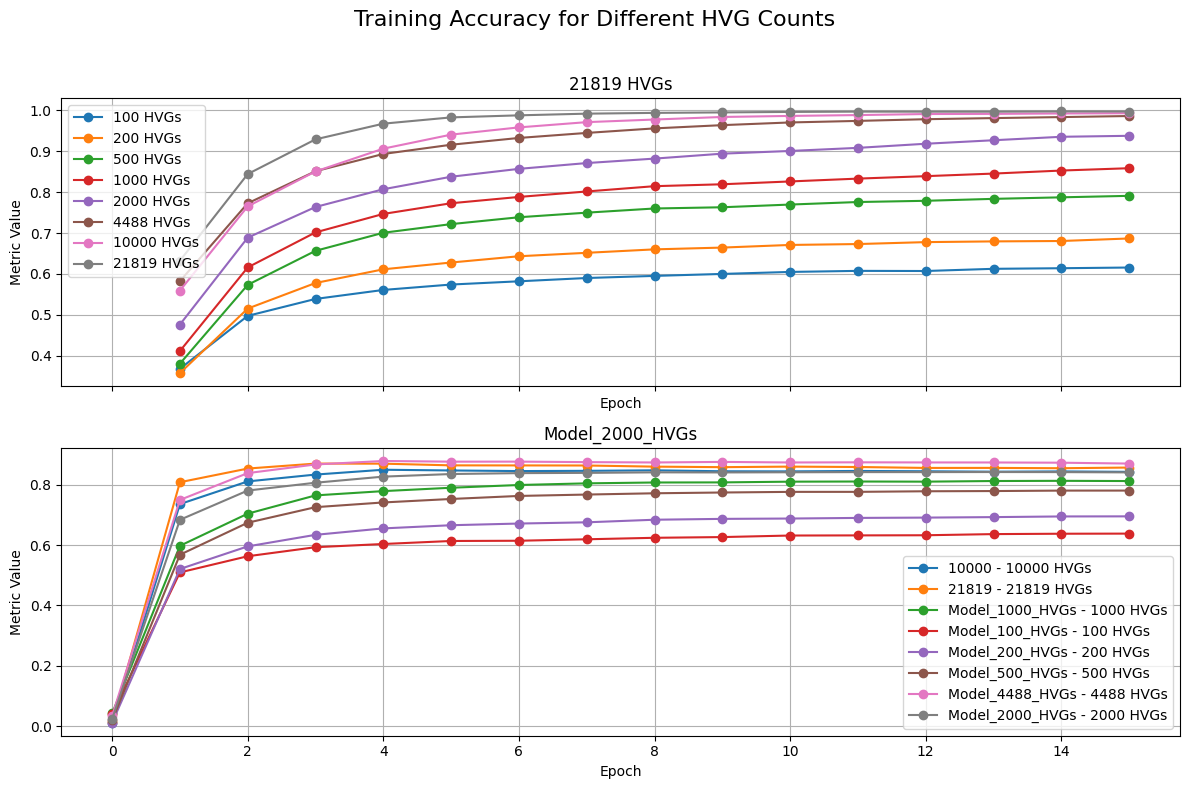

In [ ]:
json_files = [
    'Results_JSON/hvg_comparison/Accuracy_Train.json',
    'Results_JSON/hvg_comparison/Accuracy_Val.json',
]

plot_multiple_jsons_separate_subplots(json_files, title="Training Accuracy for Different HVG Counts")


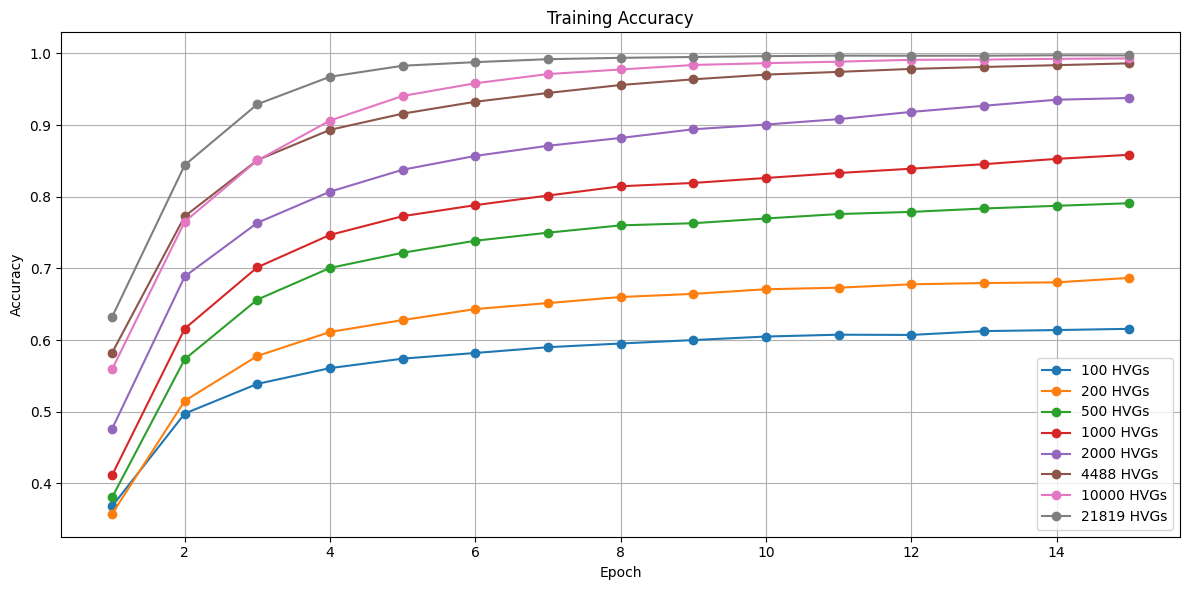

In [ ]:
plot_from_json('Results_JSON/hvg_comparison/Accuracy_Train.json', "Training Accuracy", xlabel="Epoch", ylabel="Accuracy")

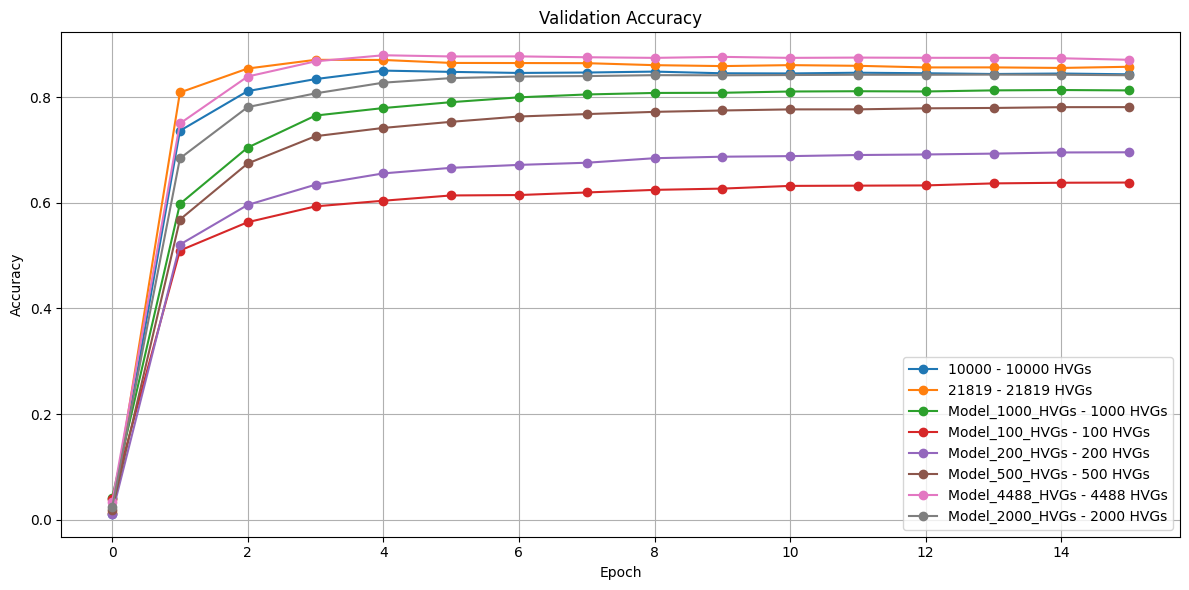

In [ ]:
plot_from_json('Results_JSON/hvg_comparison/Accuracy_Val.json', "Validation Accuracy", xlabel="Epoch", ylabel="Accuracy")